Now let's compute or robust version of the Q-Learning algorithm (in finite spaces)

Import all useful libraries

In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Import the q-learning function

In [2]:
from robust_q_learning import *

"Robust" Settings

First tests

In [3]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P1_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5)

# Adding some robustness to the model of a "fair coin"
eps = 0.1
def Pp_0(x,a):
    return binom.rvs(nr_coins, 0.5 + eps)
def pp_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5 + eps)
def Pm_0(x,a):
    return binom.rvs(nr_coins, 0.5 - eps)
def pm_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5 - eps)

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

In [4]:
Nr_iter = 100_000

Q_opt_robust, Gamma, I = robust_q_learning(X, A, r, np.array([P1_0, Pm_0, Pp_0]), np.array([p1_0, pm_0, pp_0]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 100000/100000 [22:32<00:00, 73.92it/s]


In [4]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [6]:
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
df

,State,0,1,2,3,4,5,6,7,8,9,10
0,"Robust, finite spaces",-1,-1,0,1,0,0,0,-1,-1,-1,-1


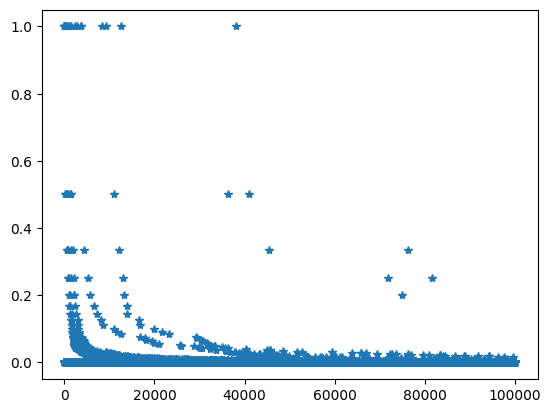

In [7]:
plt.plot(Gamma, '*')

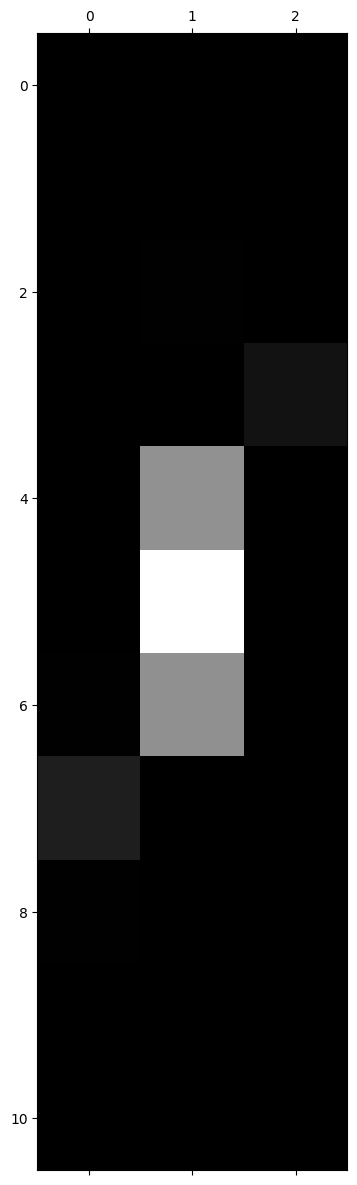

In [8]:
plt.matshow(I, cmap='gray')

In [9]:
print(sum(sum(I)))

1916.0


We can see in the robust case that because of the $\gamma_t$ formula, the extreme cases are nearly never seen and it is hard to get a correct result out of the running of our algorithm for this large case, therefore we are going to initialize our $Q_0$ with a relevant value!

Study of the sensitivity to the size of the probability range and the number of probabilities considered

First initialize our Q with the non-robust algorithm!

In [5]:
from q_learning import *

nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000
Q_opt_nonrobust = q_learning(X, A, r, P_0, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 100000/100000 [00:45<00:00, 2197.59it/s]


Then study the impact of the transition kernel

In [6]:
#EPS  = [1, 2, 0.5]
#Nr_p = [2, 5, 10, 25, 50, 100]
    
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x, a, y):
    return(a * (y > x) - a * (y < x) - np.abs(a) * (x == y)) # Reward function

def P1_0(x, a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y, nr_coins,0.5)


# Adding some robustness to the model of a "fair coin"
eps     = 1 / nr_coins
nr_prob = 10
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 200_000

Q_opt_robust_, Gamma_, I_ = robust_q_learning(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)


11


100%|██████████| 200000/200000 [18:41:20<00:00,  2.97it/s]        


In [7]:
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
df

,State,0,1,2,3,4,5,6,7,8,9,10
0,"Robust, finite spaces",1,1,1,1,1,0,-1,-1,-1,-1,-1


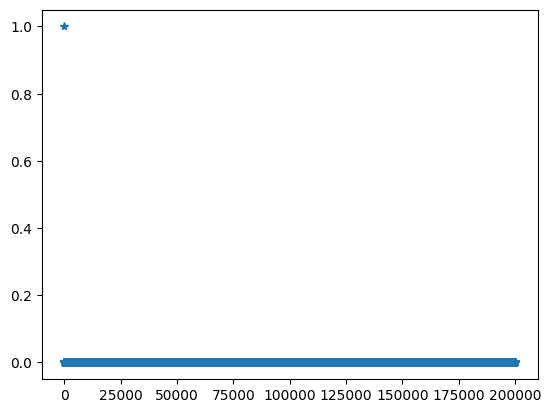

In [8]:
plt.plot(Gamma_, '*')

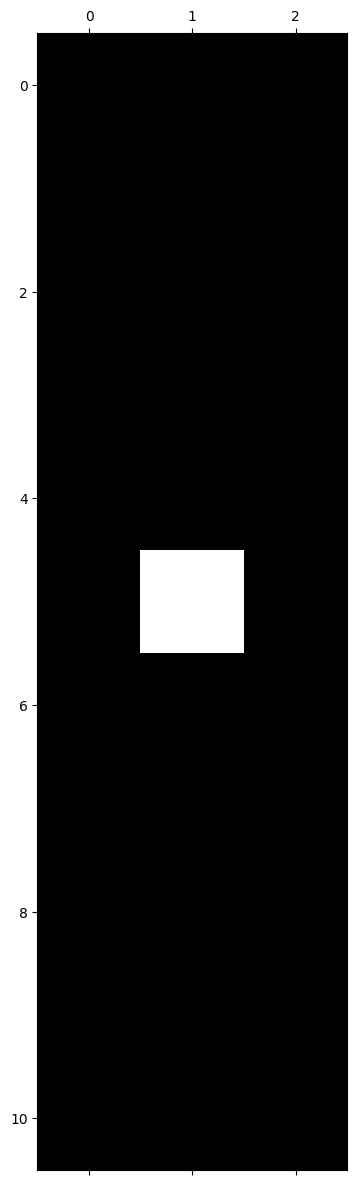

In [9]:
plt.matshow(I_, cmap='gray')

In [10]:
print(sum(sum(I_)))

1.0


And finally comparison with -Julian Sester- Wassersstein uncertainty

In [ ]:
from julian_sester__Q_learning import *